In [37]:
from IPython.display import HTML
from IPython.display import Image

Retinal images
----------

<img src='glaucomapicture.jpg' width="300" height="300" align="left">

In [38]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

Project: Glaucoma Detection
=======

**By: Pieter Leffers**

*Starting Date: March 1, 2019*

*Completion Date: -, 2019*

*Last Updated: March 18, 2019*

**Project Description**
--------

Data Source: 
    ----------

The Data: 
The data was originally collected from Kim's Eye Hospital. The images have already been pre-processed and fixed to a size of 800 pixels, centered on the optic nerve, and cropped to a size of 240 pixels.

    Kim, Ungsoo, 2018, "Machine learn for glaucoma", https://doi.org/10.7910/DVN/1YRRAC, Harvard Dataverse, V1 

The data is hosted on the Harvard Dataverse and can be downloaded at:

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/1YRRAC

I will need to keep in mind folder structure in the future since I will be porting to sagemaker with a Dockerfile and the folder structure for Sagemaker is particularly important.

*Setup Folder Tree*

    sage
    ├── Dockerfile
    ├── local_test
    │  ├── predict.sh
    │  ├── train.sh
    │  ├── serve.sh
    │  └── test_dir => /opt/ml in container
    │      ├── input
    │      │   ├── config
    │      │   └── data
    │      │       └── training
    │      ├── model
    │      └── output
    └── program
        ├── (some scripts...)
        ├── train
        └── serve

**Import Packages**

In [1]:
import random
import shutil
import numpy as np
import os
import imgaug
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
import random
from imgaug import augmenters as iaa
import imageio
import imgaug as ia

%matplotlib inline

ver=cv2.__version__
print('Matplotlib Version: {}'.format(matplotlib.__version__))
if float(ver[0])==3 and float(ver[-3:])<4.2:
    print('Please update OpenCV. This requires a minimum of OpenCV 3.4.2')
    print('Your current version is: ',cv2.__version__)
elif float(ver[0])>3:
    print('OpenCV Version:',cv2.__version__) 
else:
    print('OpenCV Version:',cv2.__version__)

Matplotlib Version: 2.2.2
OpenCV Version: 4.0.0


*Make folders*

In [2]:
DirList=['./local_test','./program',\
         './local_test/test_dir',\
         './local_test/test_dir/input',\
         './local_test/test_dir/input/config',\
         './local_test/test_dir/input/data',\
         './local_test/test_dir/input/data/training',\
         './local_test/test_dir/input/data/training/augmentation',\
         './local_test/test_dir/model',\
         './local_test/test_dir/output',\
         './local_test/program',
         './local_test/program/train',
         './local_test/program/serve',\
         './local_test/test_dir/input/data/images']#can add more folders I want to create in this process
for i in DirList:
    try:
        # Create target Directory
        os.mkdir(i)
        print("Directory " ,i,  " Created ") 
    except:
        print("Directory " ,i,  " already exists")

Directory  ./local_test  Created 
Directory  ./program  Created 
Directory  ./local_test/test_dir  Created 
Directory  ./local_test/test_dir/input  Created 
Directory  ./local_test/test_dir/input/config  Created 
Directory  ./local_test/test_dir/input/data  Created 
Directory  ./local_test/test_dir/input/data/training  Created 
Directory  ./local_test/test_dir/input/data/training/augmentation  Created 
Directory  ./local_test/test_dir/model  Created 
Directory  ./local_test/test_dir/output  Created 
Directory  ./local_test/program  Created 
Directory  ./local_test/program/train  Created 
Directory  ./local_test/program/serve  Created 
Directory  ./local_test/test_dir/input/data/images  Created 


*Pull Data*

In [3]:
#Takes a couple of hours to download
#!wget https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/1YRRAC/OGRSQO

*Extract Data*

In [ ]:
#!unzip processed_data.zip -d ./local_test/test_dir/input/data/images

*Setup Training, Testing, and Validation Folders*

In [ ]:
#!mv ./local_test/test_dir/input/data/images/advanced_glaucoma/* ./local_test/test_dir/input/data/images/early_glaucoma
#!mv ./local_test/test_dir/input/data/images/early_glaucoma ./local_test/test_dir/input/data/images/cases
#!mv ./local_test/test_dir/input/data/images/normal_control ./local_test/test_dir/input/data/images/controls
#!rm -r ./local_test/test_dir/input/data/images/advanced_glaucoma/

Setup Data Structure
--------

In [6]:
#Create training, testing, validation function, as well as a percentage for data augmentation of each

# the path to the original images
input_data_folder = "local_test/test_dir/input/data/images"
# new directory that will contain our images after computing the training and testing split
data_folder_name = "local_test/test_dir/input/data/training"

# define the percentage of the data that will be used training
training_percent = 0.8

# the amount of validation data will be a percentage of the *training* data
validation_percent = 0.1

#the amount of augmentation needed for images
augment_percent = 0.2

The two functions below were pulled from imgauge github page because I couldn't import them directly.

In [7]:
def do_assert(condition, message="Assertion failed."):
    """
    Function that behaves equally to an `assert` statement, but raises an
    Exception.
    This is added because `assert` statements are removed in optimized code.
    It replaces `assert` statements throughout the library that should be
    kept even in optimized code.
    Parameters
    ----------
    condition : bool
        If False, an exception is raised.
    message : str, optional
        Error message.
    """
    if not condition:
        raise AssertionError(str(message))

IMSHOW_BACKEND_DEFAULT = "matplotlib"
def imshow(image, backend=IMSHOW_BACKEND_DEFAULT):
    """
    Shows an image in a window.
    dtype support::
        * ``uint8``: yes; not tested
        * ``uint16``: ?
        * ``uint32``: ?
        * ``uint64``: ?
        * ``int8``: ?
        * ``int16``: ?
        * ``int32``: ?
        * ``int64``: ?
        * ``float16``: ?
        * ``float32``: ?
        * ``float64``: ?
        * ``float128``: ?
        * ``bool``: ?
    Parameters
    ----------
    image : (H,W,3) ndarray
        Image to show.
    backend : {'matplotlib', 'cv2'}, optional
        Library to use to show the image. May be either matplotlib or OpenCV ('cv2').
        OpenCV tends to be faster, but apparently causes more technical issues.
    """
    do_assert(backend in ["matplotlib", "cv2"], "Expected backend 'matplotlib' or 'cv2', got %s." % (backend,))

    if backend == "cv2":
        image_bgr = image
        if image.ndim == 3 and image.shape[2] in [3, 4]:
            image_bgr = image[..., 0:3][..., ::-1]

        win_name = "imgaug-default-window"
        cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
        cv2.imshow(win_name, image_bgr)
        cv2.waitKey(0)
        cv2.destroyWindow(win_name)
    else:
        # import only when necessary (faster startup; optional dependency; less fragile -- see issue #225)
        import matplotlib.pyplot as plt

        dpi = 96
        h, w = image.shape[0] / dpi, image.shape[1] / dpi
        w = max(w, 6)  # if the figure is too narrow, the footer may appear and make the fig suddenly wider (ugly)
        fig, ax = plt.subplots(figsize=(w, h), dpi=dpi)
        fig.canvas.set_window_title("imgaug.imshow(%s)" % (image.shape,))
        ax.imshow(image, cmap="gray")  # cmap is only activate for grayscale images
plt.show()

Build Training, Testing, and Validation Datasets
---------

Here I have created a class object so that I may consider creating a library for my needs. For the time being it is convenient to be able to simply execute the functions below with a single command. Since I was already planning on going through the trouble of supplementing images in the training set with image augmentation I decided to fold it into the same procedure as creating the training, testing, and validation sets. 

In [8]:
class preprocess_data(object):
    
    #def __init__(self,filename="",**kwargs):
    
    def create_train_test_val(data_folder_name):
        # setup the training, validation, and testing directories
        training_folder = os.path.sep.join([data_folder_name, "training"])
        validation_folder = os.path.sep.join([data_folder_name, "validation"])
        testing_folder  = os.path.sep.join([data_folder_name, "testing"])
        return training_folder,validation_folder,testing_folder

    def list_images(data_folder, contains=None):
        # import the necessary packages
        image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
        # return the set of files that are valid
        return preprocess_data.list_files(data_folder, valid_extensions=image_types, contains=contains)

    def list_files(data_folder, valid_extensions=None, contains=None):
        # loop over the directory structure
        for (root_directory, directory_names, filenames) in os.walk(data_folder):
            # loop over the filenames in the current directory
            for filename in filenames:
                # if the contains string is not none and the filename does not contain
                # the supplied string, then ignore the file
                if contains is not None and filename.find(contains) == -1:
                    continue

                # determine the file extension of the current file
                extension = filename[filename.rfind("."):].lower()

                # check to see if the file is an image and should be processed
                if valid_extensions is None or extension.endswith(valid_extensions):
                    # construct the path to the image and yield it
                    image_paths = os.path.join(root_directory, filename)
                    yield image_paths

    def images_augment(augment_percent,training_paths):
        aug_num=int(len(training_paths) * augment_percent)
        for image_iter in training_paths[:aug_num]:
            #filename,extension = (os.path.splitext(os.path.basename(image_iter)))
            #path,fullname=os.path.split(image_iter) 
            path='./local_test/test_dir/input/data/training/augmentation'
            imread_image = imageio.imread(image_iter)
            random_num=random.randint(0,360)
            rotate = iaa.Affine(rotate=(-random_num, random_num))
            image_aug = rotate.augment_image(imread_image)
            #imshow(image_aug)
            imageio.imwrite(path+'/aug_image_iter_'+str(random_num)+'.png',image_aug)
        return aug_num

    def setup_folders(training_percent,validation_percent,augment_percent):
        training_folder,validation_folder,testing_folder=preprocess_data.create_train_test_val(data_folder_name)
        # grab the paths to all input images in the original input directory and shuffle them
        image_paths = list(preprocess_data.list_images(input_data_folder))
        random.shuffle(image_paths)

        # training and testing split
        comparison = int(len(image_paths) * training_percent)
        training_paths = image_paths[:comparison]
        testing_paths = image_paths[comparison:]

        # using part of the training data for validation
        comparison = int(len(training_paths) * validation_percent)
        validation_paths = training_paths[:comparison]
        training_paths = training_paths[comparison:]  

        print('Images selected for training folder: ',len(training_paths))
        print('Images selected for testing folder: ',len(testing_paths))
        print('Images selected for validation folder: ',len(validation_paths))

        # define the datasets that we'll be building
        datasets = [("training", training_paths, training_folder),
                    ("validation", validation_paths, validation_folder),
                    ("testing", testing_paths, testing_folder)]
        
        # loop over the datasets
        for (data_type, image_paths, output_folder) in datasets:
            # show which data split we are creating
            print("\nbuilding "+data_type+" collection . . .\n")

            # if the output base output directory does not exist, create it
            if not os.path.exists(output_folder):
                print("creating "+data_type+" directory . . .")
                os.makedirs(output_folder)

            # loop over the input image paths
            for path in image_paths:
                # extract the filename of the input image along with its corresponding class label
                filename = path.split(os.path.sep)[-1]
                label = path.split(os.path.sep)[-2]
                # build the path to the label directory
                label_paths = os.path.sep.join([output_folder, label])

                # if the label output directory does not exist, create it
                if not os.path.exists(label_paths):
                    print("creating "+data_type+" directory . . .")
                    os.makedirs(label_paths)

                # construct the path to the destination image and then copy the image itself
                p = os.path.sep.join([label_paths, filename])
                shutil.copy2(path, p) #Identical to copy() except that copy2() also attempts to preserve file metadata.
                
        aug_num=preprocess_data.images_augment(augment_percent,training_paths)
        # return the total number of image paths in training, validation, and testing directories
        training_total = len(list(preprocess_data.list_images(training_folder)))
        validation_total = len(list(preprocess_data.list_images(validation_folder)))
        testing_total = len(list(preprocess_data.list_images(testing_folder)))
        total_images=training_total+validation_total+testing_total
        print('\nTraining Images: ',training_total,'\nValidation Images: ',
              validation_total,'\nTesting Images: ',testing_total,
              '\nTotal Images Selected: ',total_images,'\nAugmented Images Added: ',aug_num)
        return training_paths

  


In [9]:
training_path=preprocess_data.setup_folders(training_percent,validation_percent,augment_percent)

Images selected for training folder:  904
Images selected for testing folder:  251
Images selected for validation folder:  100

building training collection . . .

creating training directory . . .
creating training directory . . .
creating training directory . . .

building validation collection . . .

creating validation directory . . .
creating validation directory . . .
creating validation directory . . .

building testing collection . . .

creating testing directory . . .
creating testing directory . . .
creating testing directory . . .

Training Images:  904 
Validation Images:  100 
Testing Images:  251 
Total Images Selected:  1255 
Augmented Images Added:  180


I have created 180 images to help supplement my lack of images in the training folder. The reason it is merely 180 images and not more images is to avoid the augmented images being too statistically representative within the image dataset and thereby biasing the results. Below is a simple representation of the function I'm using within the class object above.

Augmented batch:


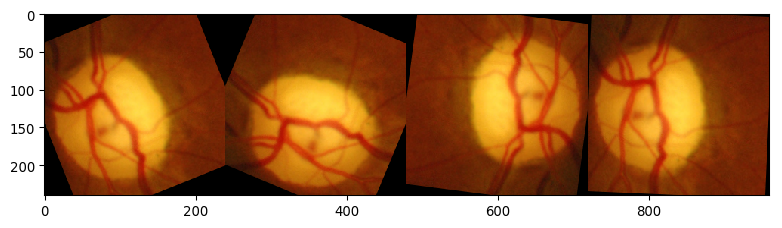

In [21]:
image = imageio.imread("local_test/test_dir/input/data/images/cases/6.png")
random_num=random.randint(0,360)
rotate = iaa.Affine(rotate=(-random_num, random_num))
images = [image, image, image, image]
images_aug = rotate.augment_images(images)

print("Augmented batch:")
imshow(np.hstack(images_aug))